In [2]:
AUDIO_DIR = 'data/audio'
AUDIO_FILEPATTERN = AUDIO_DIR + '/*.wav'
SAVE_DIR = 'models/ddsp-solo-instrument'

In [11]:
import glob
import os

if not glob.glob(AUDIO_FILEPATTERN):
    raise ValueError('No audio files found.')
                    
TRAIN_TFRECORD = 'data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

In [ ]:
!ddsp_prepare_tfrecord \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN \
    --output_tfrecord_path=$TRAIN_TFRECORD \
    --num_shards=10 \
    --alsologtostderr

In [5]:
#from ddsp.colab import colab_utils
import ddsp.training

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

#_ = colab_utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

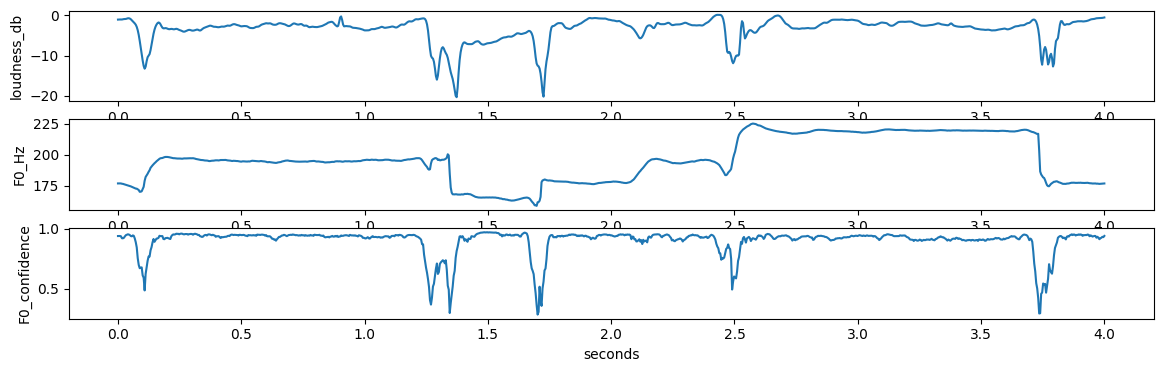

In [6]:
#from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# colab_utils.specplot(ex['audio'])
# colab_utils.play(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])

In [7]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

Reusing TensorBoard on port 6006 (pid 8516), started 0:01:51 ago. (Use '!kill 8516' to kill it.)

In [13]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='data/train.tfrecord*'" \
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"